In [ ]:
#DISCLAIMER: Mainly based on, but improved (modular, more logical: https://medium.com/@attyuttam/generative-adversarial-networks-using-pytorch-3ad31cc61ac8)

In [ ]:
# import libraries
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from IPython.display import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torch as T
import cv2
import os

%matplotlib inline

In [2]:
# load data and normalise it
data = FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = Compose(
        [ToTensor(),
         Normalize(
             mean=(0.5,),
             std=(0.5,))
        ]
    )
)

In [3]:
# define function to denormalise data
def de_norm(x):
    
    out = (x + 1) / 2
    
    return out.clamp(0, 1)

In [4]:
def show_dataset_image(datapoint):
    
    img, label = datapoint
    
    img = de_norm(img)
    
    # print image and Label
    print("Label: ", label)
    #plt.imshow(img[0])
    plt.imshow(img[0], cmap = "gray")

Label:  9


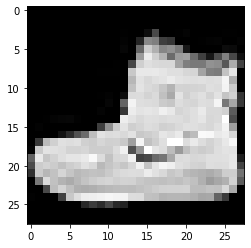

In [5]:
show_dataset_image(data[0])

In [8]:
# split dataset by label

data_dict = {
    0:[],
    1:[],
    2:[],
    3:[],
    4:[],
    5:[],
    6:[],
    7:[],
    8:[],
    9:[]
}

i = 0
for datapoint in data:
    
    img, label = datapoint
    data_dict[label].append(img)
    
    i += 1
    if i % 10000 == 0:
        print("Episode: ", i)

Episode:  10000
Episode:  20000
Episode:  30000
Episode:  40000
Episode:  50000
Episode:  60000


In [9]:
# check data distribution
for key in data_dict.keys():
    
    print(f"{key} has {len(data_dict[key])} entries.")

0 has 6000 entries.
1 has 6000 entries.
2 has 6000 entries.
3 has 6000 entries.
4 has 6000 entries.
5 has 6000 entries.
6 has 6000 entries.
7 has 6000 entries.
8 has 6000 entries.
9 has 6000 entries.


In [10]:
# define data loader for each label
batch_size = 128

data_loader_dict = {}

for key in data_dict.keys():
    
    # get dataloader
    data_loader = DataLoader(data_dict[key], batch_size, shuffle = True)
    
    # append to dict
    data_loader_dict[key] = data_loader

# get rid of data_dict (and clean memory)
data_dict = None

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self, image_size, hidden_size):
        
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        
        self.optimizer = T.optim.Adam(self.network.parameters(), lr=0.0002)
    
    def forward(self, x):
        
        x = self.network(x)
        
        return x        

In [12]:
class Generator(nn.Module):
    
    def __init__(self, latent_size, hidden_size, image_size):
        
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh()
        )
        
        self.optimizer = T.optim.Adam(self.network.parameters(), lr=0.0002)

    
    def forward(self, x):
        
        x = self.network(x)
        
        return x

In [16]:
#Training the discriminator

def reset_grad(generator, discriminator):
    
    generator.optimizer.zero_grad()
    discriminator.optimizer.zero_grad()

def train_discriminator(images, discriminator, generator, criterion):
    
    # Create the labels which are later used as input for the BCE loss
    real_labels = T.ones(batch_size, 1)
    fake_labels = T.zeros(batch_size, 1)
        
    # Loss for real images
    outputs = discriminator(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    fake_images = T.randn(batch_size, latent_size)
    fake_images = generator(fake_images)
    outputs = discriminator(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    
    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    
    # Reset gradients
    reset_grad(generator, discriminator)
    
    # Compute gradients
    d_loss.backward()
    
    # Adjust the parameters using backprop
    discriminator.optimizer.step()
    
    return d_loss, real_score, fake_score

In [17]:
def train_generator(generator, discriminator, batch_size, latent_size):
    
    # Generate fake images and calculate loss
    fake_images = T.randn(batch_size, latent_size)
    fake_images = generator(fake_images)
    labels = T.ones(batch_size, 1)
    g_loss = criterion(discriminator(fake_images), labels)

    # Backprop and optimize
    reset_grad(generator, discriminator)
    
    g_loss.backward()
    
    generator.optimizer.step()
    
    return g_loss, fake_images

# Create sample dirs and sub_dirs

In [41]:
latent_size = 64
hidden_size = 256
image_size = 28*28

# get instance of both networks for all classes
GAN_dict = {}
for index in data_loader_dict.keys():
    
    generator = Generator(
        latent_size = latent_size,
        hidden_size = hidden_size,
        image_size = image_size
    )

    discriminator = Discriminator(
        image_size = image_size,
        hidden_size = hidden_size
    )
    
    GAN_dict[index] = {
        "generator": generator,
        "discriminator": discriminator
    }

# get criterion
criterion = nn.BCELoss()

In [43]:
# function to generate fake images!
def save_fake_images(index, generator, sample_vectors, sample_dir):
    
    fake_images = generator(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    save_image(de_norm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [44]:
sample_dir = "samples"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [ ]:
num_epochs = 300

for index in data_loader_dict.keys():
    
    print("Train GAN for index: ", index)
    
    # create sub_dict
    sample_dir = f"samples/{index}"
    
    if not os.path.exists(sample_dir):
        
        os.makedirs(sample_dir)
        
    # Save some real images
    for images in data_loader_dict[index]:
        
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(de_norm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
        break
    
    # save first fake image
    sample_vectors = T.randn(batch_size, latent_size)

    save_fake_images(0, GAN_dict[index]["generator"], sample_vectors, sample_dir)
    
    # train generator and discriminator for data loader of given class
    total_step = len(data_loader_dict[0])
    
    for epoch in range(num_epochs):
        
        print(f"Epoch [{epoch}/{num_epochs}]")
        
        for i, (images) in enumerate(data_loader_dict[index]):

            try: 
                # Load a batch & transform to vectors
                images = images.reshape(batch_size, -1)

                # Train the discriminator and generator
                d_loss, real_score, fake_score = train_discriminator(
                    images, GAN_dict[index]["discriminator"], GAN_dict[index]["generator"], criterion)
                g_loss, fake_images = train_generator(
                    GAN_dict[index]["generator"], GAN_dict[index]["discriminator"], batch_size, latent_size)

                # get step
                if (i+1) % 10 == 0:

                    print(f"\t Step [{i+1}/{total_step}]")
                    
            except:
                
                # needed, because last image batch is always to small!
                continue
                
        # Sample and save images
        sample_vectors = T.randn(batch_size, latent_size)

        save_fake_images(epoch+1, GAN_dict[index]["generator"], sample_vectors, sample_dir)


Train GAN for index:  0
Epoch [0/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [1/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [2/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [3/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [4/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [5/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [6/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [7/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [8/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [9/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [10/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [11/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [12/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [13/3

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [110/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [111/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [112/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [113/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [114/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [115/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [116/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [117/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [118/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [119/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [120/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [121/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [122/300]
	 Step [10/4

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [218/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [219/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [220/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [221/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [222/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [223/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [224/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [225/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [226/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [227/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [228/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [229/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [230/300]
	 Step [10/4

	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [26/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [27/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [28/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [29/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [30/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [31/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [32/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [33/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [34/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [35/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [36/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [37/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [38/300]
	 Step [10/47]
	 Step [20

Epoch [134/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [135/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [136/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [137/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [138/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [139/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [140/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [141/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [142/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [143/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [144/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [145/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [146/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [147/3

	 Step [40/47]
Epoch [242/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [243/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [244/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [245/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [246/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [247/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [248/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [249/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [250/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [251/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [252/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [253/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [254/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/4

	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [51/300]
	 Step [10/47]
	 Step [20/47]
	 Step [30/47]
	 Step [40/47]
Epoch [52/300]
	 Step [10/47]
	 Step [20/47]


In [ ]:
# save image rows as videos
for index in data_loader_dict.keys():
    
    print("Create Video for index: ", index)
    
    # get sub_dict
    sample_dir = f"samples/{index}"
    
    # set title
    video_title = f"gan_training_{index}.avi"
    
    # get all files
    files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
    files.sort()

    # save images as video file
    out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
    [out.write(cv2.imread(fname)) for fname in files]
    out.release()